# Day 15 – Supervised vs. Unsupervised Learning
### Churn Prediction vs. Customer Segmentation (SaaS Example)

In this notebook, we’ll explore how **supervised** and **unsupervised** learning solve different business problems using the same dataset.

#### Goals:
- Simulate SaaS customer data
- Predict churn (supervised learning)
- Cluster customers (unsupervised learning)
- Compare how each method learns
- Visualize insights & interpret results

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load Real-World SaaS Dataset

In [3]:
# Load a real-world Telco Churn dataset from a public URL
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

# --- Data Cleaning and Preparation for this specific dataset ---
# Convert TotalCharges to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Drop rows with missing values (there are only a few)
df.dropna(inplace=True)

# Convert binary 'Yes'/'No' columns to 0/1
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create a numeric code for ContractType for our models
df['ContractType_Code'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

# For simplicity, let's rename 'Contract' to 'ContractType' to match the original notebook's column names
df.rename(columns={'Contract': 'ContractType'}, inplace=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractType_Code
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


## 2. Overview & Correlation

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7032 non-null   object 
 1   gender             7032 non-null   object 
 2   SeniorCitizen      7032 non-null   int64  
 3   Partner            7032 non-null   object 
 4   Dependents         7032 non-null   object 
 5   tenure             7032 non-null   int64  
 6   PhoneService       7032 non-null   object 
 7   MultipleLines      7032 non-null   object 
 8   InternetService    7032 non-null   object 
 9   OnlineSecurity     7032 non-null   object 
 10  OnlineBackup       7032 non-null   object 
 11  DeviceProtection   7032 non-null   object 
 12  TechSupport        7032 non-null   object 
 13  StreamingTV        7032 non-null   object 
 14  StreamingMovies    7032 non-null   object 
 15  ContractType       7032 non-null   object 
 16  PaperlessBilling   7032 non-n

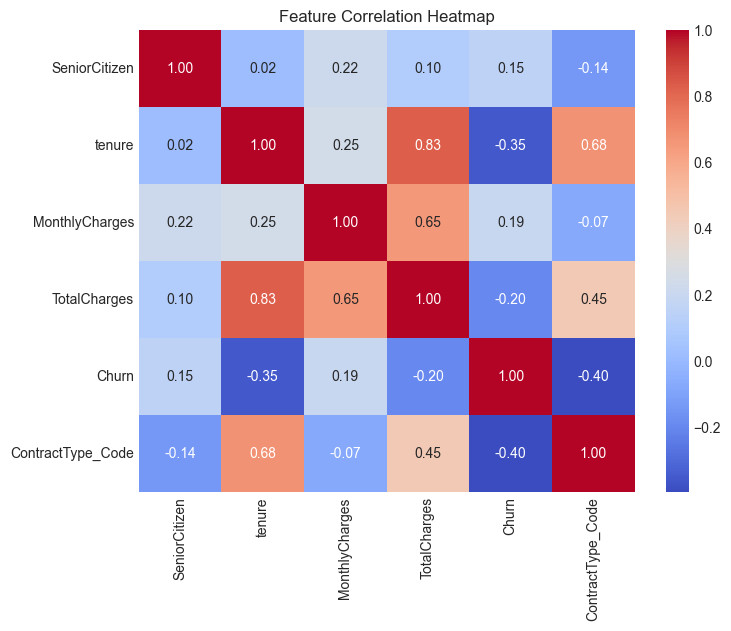

In [4]:
df.info()
print(df.describe()[['tenure','MonthlyCharges','TotalCharges']])

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

## 3. Supervised Learning — Logistic Regression for Churn Prediction

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1300
           1       0.59      0.48      0.53       458

    accuracy                           0.78      1758
   macro avg       0.71      0.68      0.69      1758
weighted avg       0.77      0.78      0.77      1758



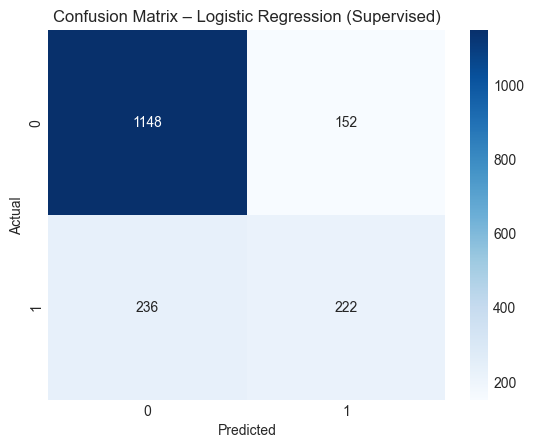

In [5]:
# Feature selection
X = df[['tenure','MonthlyCharges','TotalCharges','ContractType_Code']]
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Logistic Regression (Supervised)')
plt.show()

### 🔍 Insight
- Supervised model uses *labeled data* (Churn = 0 or 1)
- It learns a mapping between inputs and the known target
- Evaluation uses metrics like accuracy, precision, recall

## 4. Unsupervised Learning — KMeans Clustering for Segmentation

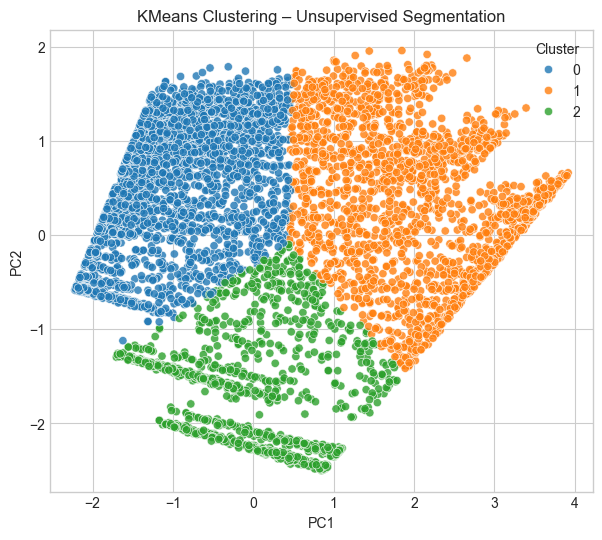

In [6]:
# Use same features (ignore churn label)
X_scaled = StandardScaler().fit_transform(X)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# Visualize with PCA for 2D projection
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_scaled)
df['PC1'], df['PC2'] = pca_features[:,0], pca_features[:,1]

plt.figure(figsize=(7,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='tab10', alpha=0.8)
plt.title('KMeans Clustering – Unsupervised Segmentation')
plt.show()

### 🔍 Insight
- Unsupervised model uses *no labels*.
- Finds hidden structure (natural segments) within the data.
- Clusters may represent groups like “power users” or “at-risk” customers.

## 5. Compare Supervised vs. Unsupervised Results

C:\Users\vedav\AppData\Local\Temp\ipykernel_15492\1460673232.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Churn', data=df, palette='coolwarm')


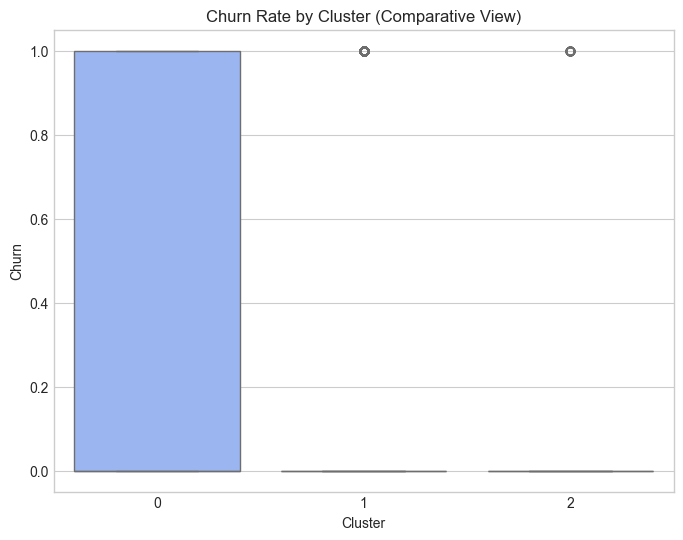

,tenure,MonthlyCharges,TotalCharges,Churn
Cluster,,,,
0,13.81,63.19,929.75,0.42
1,59.11,91.69,5412.53,0.14
2,42.28,29.55,1255.95,0.03


In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='Churn', data=df, palette='coolwarm')
plt.title('Churn Rate by Cluster (Comparative View)')
plt.show()

# Cluster summary
summary = df.groupby('Cluster')[['tenure','MonthlyCharges','TotalCharges','Churn']].mean().round(2)
summary

### 🧠 Interpretation
- **Supervised:** Learns to *predict churn directly* from past data.
- **Unsupervised:** *Finds hidden groups* based on behavioral similarity.
- In business: Combine both → Cluster first, then predict churn per segment → smarter targeting.

## 6. Summary
✅ Supervised → Predictive (needs labeled data)
✅ Unsupervised → Exploratory (finds structure)
✅ Both → Complementary for customer intelligence

**Deliverable:** `day15_supervised_vs_unsupervised.ipynb`